In [1]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder

## Quick Look at the Data
There's some example data provided in the `test_dataset` folder.  This basic dataset is enough to get you up and running but if you want to hone your methods more carefully you should record some data of your own to sample various scenarios in the simulator.  

Next, read in and display a random image from the `test_dataset` folder

## Rover Project Test Notebook
This notebook contains the functions from the lesson and provides the scaffolding you need to test out your mapping methods.  The steps you need to complete in this notebook for the project are the following:

* First just run each of the cells in the notebook, examine the code and the results of each.
* Run the simulator in "Training Mode" and record some data. Note: the simulator may crash if you try to record a large (longer than a few minutes) dataset, but you don't need a ton of data, just some example images to work with.   
* Change the data directory path (2 cells below) to be the directory where you saved data
* Test out the functions provided on your data
* Write new functions (or modify existing ones) to report and map out detections of obstacles and rock samples (yellow rocks)
* Populate the `process_image()` function with the appropriate steps/functions to go from a raw image to a worldmap.
* Run the cell that calls `process_image()` using `moviepy` functions to create video output
* Once you have mapping working, move on to modifying `perception.py` and `decision.py` to allow your rover to navigate and map in autonomous mode!

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

**Run the next cell to get code highlighting in the markdown cells.**

In [2]:
path = '../dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

ValueError: low >= high

## Calibration Data
Read in and display example grid and rock sample calibration images.  You'll use the grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest. 

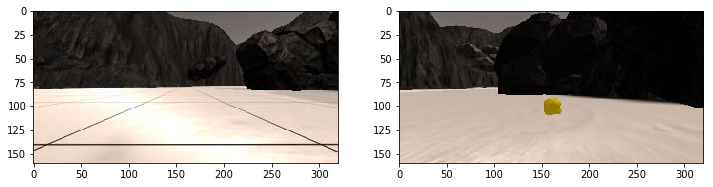

In [5]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## Perspective Transform

Define the perspective transform function from the lesson and test it on an image.

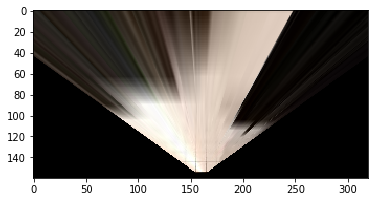

In [6]:
# Define a function to perform a perspective transform
# I've used the example grid image above to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    return warped


# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
# this is just a rough guess, feel free to change it!
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped = perspect_transform(grid_img, source, destination)
plt.imshow(warped)
#scipy.misc.imsave('../output/warped_example.jpg', warped)

## Color Thresholding
Define the color thresholding function from the lesson and apply it to the warped image

**TODO:** Ultimately, you want your map to not just include navigable terrain but also obstacles and the positions of the rock samples you're searching for.  Modify this function or write a new function that returns the pixel locations of obstacles (areas below the threshold) and rock samples (yellow rocks in calibration images), such that you can map these areas into world coordinates as well.  
**Hints and Suggestion:** 
* For obstacles you can just invert your color selection that you used to detect ground pixels, i.e., if you've decided that everything above the threshold is navigable terrain, then everthing below the threshold must be an obstacle!


* For rocks, think about imposing a lower and upper boundary in your color selection to be more specific about choosing colors.  You can investigate the colors of the rocks (the RGB pixel values) in an interactive matplotlib window to get a feel for the appropriate threshold range (keep in mind you may want different ranges for each of R, G and B!).  Feel free to get creative and even bring in functions from other libraries.  Here's an example of [color selection](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html) using OpenCV.  

* **Beware However:** if you start manipulating images with OpenCV, keep in mind that it defaults to `BGR` instead of `RGB` color space when reading/writing images, so things can get confusing.

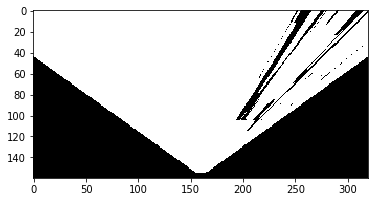

In [7]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(0, 0, 0)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

threshed = color_thresh(warped)
plt.imshow(threshed, cmap='gray')
#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

## Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

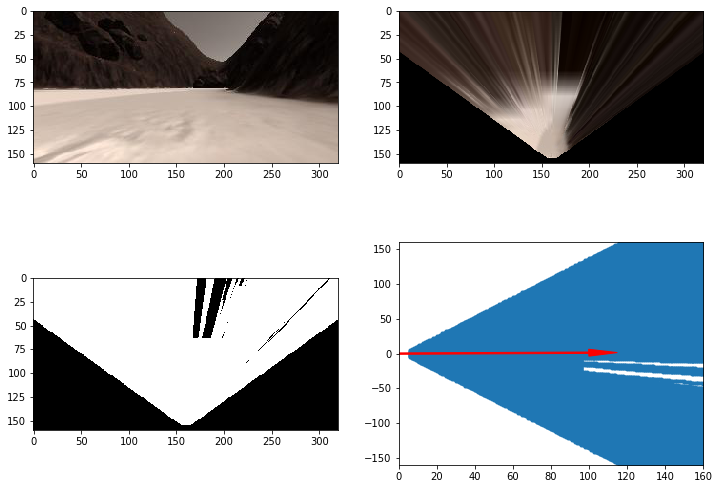

In [8]:
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = np.absolute(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[0]).astype(np.float)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to apply a rotation to pixel positions
def rotate_pix(xpix, ypix, yaw):
    # TODO:
    # Convert yaw to radians
    # Apply a rotation
    xpix_rotated = 0
    ypix_rotated = 0
    # Return the result  
    return xpix_rotated, ypix_rotated

# Define a function to perform a translation
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # TODO:
    # Apply a scaling and a translation
    xpix_translated = 0
    ypix_translated = 0
    # Return the result  
    return xpix_translated, ypix_translated

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)



## Read in saved data and ground truth map of the world
The next cell is all setup to read your saved data into a `pandas` dataframe.  Here you'll also read in a "ground truth" map of the world, where white pixels (pixel value = 1) represent navigable terrain.  

After that, we'll define a class to store telemetry data and pathnames to images.  When you instantiate this class (`data = Databucket()`) you'll have a global variable called `data` that you can refer to for telemetry and map data within the `process_image()` function in the following cell.  


In [9]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
# Change the path below to your data directory
# If you are in a locale (e.g., Europe) that uses ',' as the decimal separator
# change the '.' to ','
df = pd.read_csv('../dataset/robot_log.csv', delimiter=',', decimal='.')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = -1 # This will be a running index, setting to -1 is a hack
                        # because moviepy (below) seems to run one extra iteration
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()


## Write a function to process stored images

Modify the `process_image()` function below by adding in the perception step processes (functions defined above) to perform image analysis and mapping.  The following cell is all set up to use this `process_image()` function in conjunction with the `moviepy` video processing package to create a video from the images you saved taking data in the simulator.  

In short, you will be passing individual images into `process_image()` and building up an image called `output_image` that will be stored as one frame of video.  You can make a mosaic of the various steps of your analysis process and add text as you like (example provided below).  



To start with, you can simply run the next three cells to see what happens, but then go ahead and modify them such that the output video demonstrates your mapping process.  Feel free to get creative!

In [10]:

# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img):
    # Example of how to use the Databucket() object defined above
    # to print the current x, y and yaw values
    print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])

    # TODO:
    # 1) Define source and destination points for perspective transform
    # Define calibration box in source (actual) and destination (desired) coordinates
    # These source and destination points are defined to warp the image
    # to a grid where each 10x10 pixel square represents 1 square meter
    # The destination box will be 2*dst_size on each side
    img_size = (img.shape[1], img.shape[0])
    dst_size = 5
    # Set a bottom offset to account for the fact that the bottom of the image
    # is not the position of the rover but a bit in front of it
    bottom_offset = 6
    src = np.float32([[14, 140], [301, 140], [200, 96], [118, 96]])
    dst = np.float32([[img_size[0] / 2 - dst_size, img_size[1] - bottom_offset],
                      [img_size[0] / 2 + dst_size, img_size[1] - bottom_offset],
                      [img_size[0] / 2 + dst_size, img_size[1] - 2 * dst_size - bottom_offset],
                      [img_size[0] / 2 - dst_size, img_size[1] - 2 * dst_size - bottom_offset],
                      ])

    # 2) Apply perspective transform
    warped = perspect_transform(img, src, dst)

    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    navigable = color_thresh(warped, rgb_thresh=(160, 160, 160))
    obstacle = color_thresh(warped, rgb_thresh=(100,100,100))
    rocks = color_thresh(warped, rgb_thresh=(200,200,200))

    # 4) Convert thresholded image pixel values to rover-centric coords
    navigable_xpix, navigable_ypix = rover_coords(navigable)
    rocks_xpix, rocks_ypix = rover_coords(rocks)
    obstacle_xpix, obstacle_ypix = rover_coords(obstacle)
    
    # 5) Convert rover-centric pixel values to world coords
    rover_xpos = np.random.random(1)*160 + 20
    rover_ypos = np.random.random(1)*160 + 20
    rover_yaw = np.random.random(1)*360
    worldmap = np.zeros((200, 200))
    scale = 10
    navigable_x_world, navigable_y_world = pix_to_world(navigable_xpix, navigable_ypix, rover_xpos,
                                    rover_ypos, rover_yaw,
                                    worldmap.shape[0], scale)
    rocks_x_world, rocks_y_world = pix_to_world(rocks_xpix, rocks_ypix, rover_xpos,
                                    rover_ypos, rover_yaw,
                                    worldmap.shape[0], scale)
    obstacle_x_world, obstacle_y_world = pix_to_world(obstacle_xpix, obstacle_ypix, rover_xpos,
                                    rover_ypos, rover_yaw,
                                    worldmap.shape[0], scale)
    
    # 6) Update worldmap (to be displayed on right side of screen)
    data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1 #obstacle world
    data.worldmap[rocks_y_world, rocks_x_world, 1] += 1 #rocks world
    data.worldmap[navigable_y_world, navigable_x_world, 2] += 1 # navigable world

    # 7) Make a mosaic image, below is some example code
        # First create a blank image (can be whatever shape you like)
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
        # Next you can populate regions of the image with various output
        # Here I'm putting the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

        # Let's create more images to add to the mosaic, first a warped image
        # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

        # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
        # Flip map overlay so y-axis points upward and add to output_image
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)


        # Then putting some text over the image
    cv2.putText(output_image,"Populate this image with your analyses to make a video!", (20, 20),
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    data.count += 1 # Keep track of the index in the Databucket()

    return output_image

## Make a video from processed image data
Use the [moviepy](https://zulko.github.io/moviepy/) library to process images and create a video.
  

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = '../output/mapping-result.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=60) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

123.7587 101.2399 24.30054
[MoviePy] >>>> Building video ../output/mapping-result.mp4
[MoviePy] Writing video ../output/mapping-result.mp4


  3%|▎         | 5/170 [00:00<00:03, 47.34it/s]

99.66999 85.58897 56.82556
99.66999 85.58897 56.82556
99.66999 85.58897 56.82556
99.66999 85.58897 56.82556
99.66999 85.58897 56.82556
99.66999 85.58897 56.82556
99.66999 85.58897 56.82556
99.66999 85.58897 56.82556
99.66999 85.58897 56.82556
99.66999 85.58897 56.82556
99.66999 85.58897 56.82556


 11%|█         | 18/170 [00:00<00:02, 52.93it/s]

99.66999 85.58897 56.82556
99.66999 85.58897 56.82556
99.66999 85.58897 56.82556
99.66999 85.58897 56.82556
99.66999 85.58897 56.82556
99.67003 85.58904 56.82557
99.67078 85.59019 56.83363
99.67252 85.59285 56.96656
99.67665 85.59918 56.77574
99.68203 85.60735 56.73293
99.68893 85.61783 56.6171
99.70153 85.63695 56.67214
99.71305 85.65435 

 18%|█▊        | 30/170 [00:00<00:02, 54.48it/s]

56.71386
99.72495 85.67239 56.70098
99.74044 85.69588 56.73088
99.75468 85.71731 56.58786
99.7714 85.74245 56.55003
99.79698 85.77998 56.48396
99.81894 85.81041 56.25228
99.84323 85.84241 56.04285
99.87853 85.886 55.26936
99.90881 85.92123 54.46297
99.94138 85.95767 53.47837
99.98898 86.00919 52.10427
100.0277 86.04933 51.01929


 25%|██▍       | 42/170 [00:00<00:02, 55.78it/s]

100.0695 86.091 49.94569
100.1292 86.14812 48.55124
100.1772 86.19207 47.38143
100.2277 86.23782 46.32202
100.2988 86.30175 45.15779
100.3545 86.35193 44.49386
100.4117 86.4044 44.09015
100.4906 86.47858 43.88204
100.5517 86.53678 43.85604
100.6149 86.597 43.8399
100.7023 86.68033 43.82221


 28%|██▊       | 48/170 [00:00<00:02, 50.18it/s]

100.7703 86.74503 43.81175
100.8403 86.81167 43.79911
100.9368 86.90347 43.78441
101.0115 86.97448 43.77468
101.0882 87.04742 43.76349
101.1937 87.1476 43.74755


 32%|███▏      | 54/170 [00:01<00:02, 51.57it/s]

101.275 87.22485 43.73817
101.3585 87.30403 43.72532
101.4727 87.41239 43.71119
101.5607 87.49583 43.70069


 35%|███▌      | 60/170 [00:01<00:02, 49.99it/s]

101.6507 87.58113 43.68817
101.7737 87.69765 43.67345
101.8681 87.78714 43.66246
101.9646 87.87845 43.65253
102.0963 88.00301 43.63599
102.1972 88.09848 43.62527
102.3001 88.19576 43.61307
102.4403 88.32822 43.59929


 39%|███▉      | 66/170 [00:01<00:02, 50.70it/s]

102.5477 88.4296 43.58615
102.657 88.53277 43.57432


 42%|████▏     | 72/170 [00:01<00:02, 48.71it/s]

102.8057 88.67307 43.55898
102.9194 88.78033 43.54772
103.0349 88.88921 43.53592
103.192 89.03721 43.51838
103.312 89.15022 43.50567
103.4338 89.2649 43.49394
103.5992 89.42043 43.47858


 45%|████▌     | 77/170 [00:01<00:02, 46.00it/s]

103.7253 89.53901 43.46676
103.8533 89.65936 43.45412
104.0269 89.8224 43.43576


 48%|████▊     | 82/170 [00:01<00:01, 46.74it/s]

104.1592 89.94658 43.42308
104.2934 90.07251 43.40906
104.4751 90.24289 43.39101
104.6135 90.37265 43.37665
104.7537 90.50397 43.36266
104.9435 90.68166 43.3429
105.0879 90.81681 43.3283
105.2341 90.95358 43.31382
105.4319 91.13844 43.29277
105.5823 91.27888 43.2756


 54%|█████▍    | 92/170 [00:01<00:01, 45.02it/s]

105.7345 91.42095 43.25946
105.9402 91.61285 43.23864
106.0965 91.75854 43.2201
106.2546 91.90582 43.20319
106.4682 92.10464 43.18095
106.6304 92.25555 43.16143
106.7944 92.40797 43.14298
107.0157 92.61361 43.11919
107.1837 92.76957 43.10006
107.3535 92.92704 43.07956


 57%|█████▋    | 97/170 [00:01<00:01, 43.91it/s]

107.5826 93.13937 43.05376
107.7564 93.30032 43.03272
107.932 93.46281 43.01253
108.1697 93.68069 42.74423


 60%|██████    | 102/170 [00:02<00:01, 43.78it/s]

108.3515 93.84375 42.16508
108.5371 94.00537 41.20768
108.7923 94.21488 39.24478
108.9894 94.36505 37.23379
109.1912 94.50767 34.97087

 63%|██████▎   | 107/170 [00:02<00:01, 42.88it/s]


109.4668 94.68481 31.88862
109.6779 94.80873 29.74292
109.8933 94.93142 27.92568
110.1868 95.09248 25.95437


 66%|██████▌   | 112/170 [00:02<00:01, 42.47it/s]

110.4122 95.20743 25.08105
110.6406 95.31547 24.61592
110.9433 95.45455 24.4117
111.169 95.55708 24.37187
111.3934 95.65868 24.35918


 69%|██████▉   | 117/170 [00:02<00:01, 40.89it/s]

111.6907 95.79301 24.35499
111.9122 95.89304 24.35461
112.1326 95.99253 24.35482
112.425 96.12433 24.35091
112.6437 96.2226 24.33963
112.8617 96.32059 24.32763
113.1515

 72%|███████▏  | 122/170 [00:02<00:01, 42.03it/s]

 96.45087 24.31352
113.3681 96.54819 24.30051
113.584 96.64528 24.29124


 75%|███████▍  | 127/170 [00:02<00:01, 42.82it/s]

113.8709 96.77444 24.28223
114.085 96.87104 24.28091
114.299 96.96711 24.26751
114.5828 97.09515 24.26369
114.795 97.1915 24.27719
115.0066 97.28723 24.28417
115.2877 97.41415 24.28681
115.4978 97.50964 24.30229


 78%|███████▊  | 132/170 [00:02<00:00, 43.90it/s]

115.7073 97.60434 24.30646
115.9853 97.72991 24.30778


 81%|████████  | 137/170 [00:02<00:00, 44.12it/s]

116.1929 97.82366 24.30791
116.4 97.91768 24.32041
116.675 98.04192 24.32413
116.8808 98.13443 24.31414
117.0858 98.22684 24.30907
117.3576 98.34956 24.30738
117.5606 98.44117 24.30711
117.7632 98.53223 24.29585

 84%|████████▎ | 142/170 [00:03<00:00, 44.06it/s]


118.0319 98.65349 24.29263


 86%|████████▋ | 147/170 [00:03<00:00, 43.38it/s]

118.2324 98.74402 24.2922
118.4323 98.83463 24.3009
118.6977 98.95465 24.30603
118.8959 99.04417 24.30687
119.0935 99.13332 24.30518
119.356 99.25184 24.30401
119.552 99.34033 24.30382
119.7473 99.42858 24.30489


 89%|████████▉ | 152/170 [00:03<00:00, 42.76it/s]

120.0068 99.54582 24.30661
120.2005 99.63331 24.30687
120.3937 99.72031 24.30128
120.6503 99.836 24.29433
120.8418 99.92246 24.2933


 92%|█████████▏| 157/170 [00:03<00:00, 41.37it/s]

121.0328 100.0091 24.30328
121.2863 100.1237 24.30606
121.4756 100.2091 24.30646
121.6644 100.2944 24.30618
121.9151 100.4076 24.30599


 95%|█████████▌| 162/170 [00:03<00:00, 40.96it/s]

122.1022 100.4921 24.30595
122.2889 100.5761 24.29779
122.5368 100.6879 24.29371
122.7218 100.7716 24.29803


 98%|█████████▊| 167/170 [00:03<00:00, 43.02it/s]

122.9063 100.8551 24.30346
123.1512 100.9658 24.30503
123.334 101.0483 24.30525
123.5165 101.1306 24.30141


100%|██████████| 170/170 [00:03<00:00, 45.94it/s]


123.7587 101.2399 24.30054
[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/mapping-result.mp4 

CPU times: user 2.45 s, sys: 782 ms, total: 3.23 s
Wall time: 3.98 s


### This next cell should function as an inline video player
If this fails to render the video, try running the following cell (alternative video rendering method).  You can also simply have a look at the saved mp4 in your `/output` folder

In [12]:

from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### Below is an alternative way to create a video in case the above cell did not work.

In [13]:
import io
import base64
video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))